# Lab 4: Exploring overfitting, validation and regularisation in regression

Our main goal in machine learning is to create models that will perform well **during deployment**. In contrast to other engineering and scientific approches, in machine learning we **lack a perfect despription** of the target population and all we can do is **sample data** from the population. We use data in different **tasks**: to build our models (**train**), to assess their deployment performance (**test**) and to select a suitable family of models for training (**validation**).

In Lab 3, we obtained the least square solution of four families of polynomial models, namely polynomials of degree 1 (linear), 2 (quadratic), 3 (cubic) and 4. Least squares is an exact method and provides the **optimal model** defined by the **empirical error surface**. As you know, the optimal model defined by the empirical error surface is in general different from the optimal model defined by the **true error surface**, which is the model that we are actually looking for. This distinction is important, as our models could perform very well during training, but very poorly during deployment. In such cases, we talk about **overfitting**.

Overfitting occurs in scenarios where we have **small dataset** and **complex models** and can be detected by comparing the training performance and the deployment performance. Overfitting can be avoided by having large enough datasets and by controlling the complexity of our models. We can identify the right complexity of our models using **validation** approaches. **Regularisation** methods can also be used to control the flexibility of our models. 

In this lab we explore overfitting, validation and regularisation in a regression problem. Make sure you revise the contents of weeks 2 and 3, as this lab will illustrate many of the concepts that we have discussed during our lectures and will help you to develop a strong intuition.

# A simple regression problem

In this lab, we will explore the same simple dataset that we used in Lab 3. This dataset consists of 10 samples described by one predictor `x` and one label `y`. Let's define and plot the dataset.


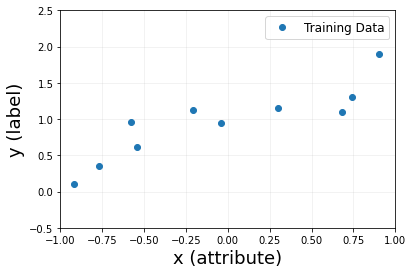

In [8]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

xTrain = np.array([0.3000, -0.7700, 0.9000, -0.0400, 0.7400, -0.5800, -0.9200, -0.2100, -0.5400, 0.6800])
yTrain = np.array([1.1492,  0.3582, 1.9013,  0.9487, 1.3096,  0.9646,  0.1079,  1.1262,  0.6131, 1.0951])

plt.plot(xTrain, yTrain, 'o', label="Training Data")
plt.xlabel("x (attribute)", fontsize=18)
plt.ylabel("y (label)", fontsize=18)
plt.xlim(-1,1)
plt.ylim(-0.5,2.5)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.show()

Our next step will be to obtain the **least squares linear** fit. In this lab we will take advantage of the implementation of least squares provided by NumPy (`polyfit`) instead of implementing least squares ourselves. You can find more information about `polyfit` [here](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).

In [9]:
order = 1
w = np.polyfit(xTrain, yTrain, order)
print("The coefficients of the least squares linear solution are: ", w)

The coefficients of the least squares linear solution are:  [0.662 0.987]


These coefficients should be the same as the ones we obtained in Lab 3 with our own implementation of least squares. 

NumPy also provides `poli1d`, a library class that encapsulates operations involving polynomials. Using `poli1d` is very simple and is described [here](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html). Let's create a *NumPy polynomial object* defined by the coefficients returned by `polyfit` and print it.

In [10]:
p = np.poly1d(w)
print("The mathematical expression of the fitted linear model is : ", p)
print("The coefficients of the model are : ", p.c)

The mathematical expression of the fitted linear model is :   
0.6621 x + 0.9865
The coefficients of the model are :  [0.662 0.987]


Once the linear solution `p` has been created, making a prediction is easy. We just need to pass the predictor `x` to the polynomial as follows:

In [17]:
x = 0
yPred = p(x)
print("Given a predictor x = ", x, " the predicted label is y = ", yPred)

Given a predictor x =  0  the predicted label is y =  0.9865231644203777


You can try several values of $x$ and obtained the predicted label. 

Let's plot the least squares linear model together with the training dataset: 

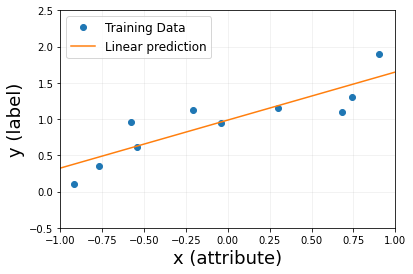

In [5]:
x_LS = np.linspace(-1,1,100).T
y_LS = p(x_LS)

plt.plot(xTrain, yTrain, 'o', label="Training Data")
plt.plot(x_LS, y_LS, label="Linear prediction")
plt.xlabel("x (attribute)", fontsize=18)
plt.ylabel("y (label)", fontsize=18)
plt.xlim(-1,1)
plt.ylim(-0.5,2.5)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.show()

What is the quality of this linear model? Least squares uses the mean squared error (MSE) as quality metric. Remember that the MSE is defined as 

$E_{MSE} = \frac{1}{N}\sum_{i=1}^{N}{e_i^2}=\frac{1}{N}\sum_{i=1}^{N}{(y_i-\hat{y}_i)^2}$ 

where $N$ is the number of samples, $y_i$ is the true label and $\hat{y}_i$ is the predicted label. Let's show step by step how to obtain the training MSE of the fitted linear model:



In [27]:
yPredTrain = p(xTrain)
error = yTrain - yPredTrain
errorSq = error**2
MSETrain = np.sum(errorSq)/10

print("The predictors are         ", xTrain)

print("\nThe true labels are        ", yTrain)

print("\nThe predicted labels s are ", yPredTrain)

print("\nThe errors are             ", error)

print("\nThe squared errors are ", errorSq)

print("\nThe training MSE is ", MSETrain)

The predictors are          [ 0.3  -0.77  0.9  -0.04  0.74 -0.58 -0.92 -0.21 -0.54  0.68]

The true labels are         [1.149 0.358 1.901 0.949 1.31  0.965 0.108 1.126 0.613 1.095]

The predicted labels s are  [1.185 0.477 1.582 0.96  1.476 0.602 0.377 0.847 0.629 1.437]

The errors are              [-0.036 -0.118  0.319 -0.011 -0.167  0.362 -0.269  0.279 -0.016 -0.342]

The squared errors are  [1.293e-03 1.404e-02 1.017e-01 1.286e-04 2.785e-02 1.311e-01 7.262e-02
 7.769e-02 2.522e-04 1.167e-01]

The training MSE is  0.05434014916039903


Have a look at the graph showing the training data and the least squares linear model. Make sure that the individual errors that you have obtained make sense to you before moving ahead. For instance, check those samples where the error is close to zero or identify the samples that have a negative value.


# Complexity and training MSE


As we increase the order of a polynomial model, its flexibility increases. Flexible models can produce complex shapes and will therefore be able to reproduce complex patterns. Because of this, flexible models will always make **better predictions** during **training**. There is a risk, as you know. Our training dataset is the result of a **pattern** (which we want to discover) and **irrelevant details** (or noise, which we want to ignore). During optimisation we ask our models to make the best predictions that they can, however this prediction includes both pattern and irrelevant details. The higher the complexity of the model, the higher the risk to learn those irrelevant details, and this will result in a poorer deployment performance. 

In this section, we will fit several polynomial models of degrees 1 (linear) to 9 to our dataset. We will also obtain the training MSE of each model and the sum of squares of their coefficients (SSC), defined as:

$SSC = \sum_{d=0}^{D}{w_d^2}$

where $D$ is the degree of the polynomial and $w_d$ are the coefficients.

In [7]:
from google.colab import widgets

orders = range(1,10)
tb = widgets.TabBar([str(order) for order in orders])

for order in orders:
    with tb.output_to(str(order), select = (order < 2)):

        p = np.poly1d(np.polyfit(xTrain, yTrain, int(order)))

        yPredTrain = p(xTrain)
        error = yTrain - yPredTrain
        errorSq = error**2
        MSE_Train = np.sum(errorSq)/10

        plt.plot(xTrain, yTrain, 'o', label='Train data')
        plt.plot(x_LS, p(x_LS), '-', alpha=0.8, label='Learned model', linewidth=2)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("y",fontsize=14)
        plt.xlim(-1,1)
        plt.ylim(-0.5,2.5)
        plt.grid(alpha=0.2)
        plt.legend(loc='upper left', fontsize=12)
        plt.show()

        print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(p.c))
        print('The fitted model is:\n {} \n\n---\n'.format(p))
        print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train))
        print("The SSC is: {:8.3f}".format(sum(p.c**2)))



ModuleNotFoundError: No module named 'google'

At this point, it is worth to stop and analyse the results that you have obtained. Specifically, focus on:


* The **coefficients** of the fitted models and their **mathematical expression**.
* The **shape** of the fitted models. Could you explain why a polynomial of degree 9 is more flexible than a polynomial of degree 1? Visually, which one makes the best prediction on the training dataset?
*   The **training MSE**. How does it change as we increase the degree of the polynomial model? According to the training MSE value, which one makes the best prediction on the training dataset? Is it consistent with your visual interpretation?
*   The **SSC** value. How does it change as we increase the degree of the polynomial? Have a look at the mathematical expression of the fitted models. Can you see that the **SSC** value tells us how large the coefficients are?

And now the final question. **Could you tell which model is overfitting**? Try to justify very clearly why and discuss it with your classmates.


# Overfitting and validation

A model is overfitting when it performs very well on the training dataset but exhibits a poor deployment performance. The polynomial of degree 9 performs really well on our training dataset. This might look suspicious to you, but until we assess a model's deployment performance, we cannot say that the model is overfitting. 

The training error is used for tuning a model, but never for assessing its deployment performance. **Test tasks** include a separate dataset (the test dataset) to assess the performance of a final model. **Validation tasks** are used to select a suitable family of models to be trained, and involve several rounds where we train a family of models with one dataset and assess its deployment performance with another dataset.

In this section, we will implement a simple validation task to identify the right degree for our polynomial. Specifically, we will implement a **validation set** approach. After selecting the best polynomial model, we will retrain it with all the data available to produce our final model.

Let's assume that the data used for training is the same that we used before and that the validation dataset is as follows:

In [28]:
xVal = np.array([0.1100, 0.2300, 0.1800, 0.3500, 0.5200, -0.4400, -0.6900, -0.2400, 0.4300, -0.4100, 0.3300, 0.8800, -0.4300, 0.5600, 0.6600, -0.0100, -0.8300, 0.5700, 0.3400, 0.6700])
yVal = np.array([1.0569, 1.0647, 0.9575, 1.2097, 0.8371, 0.8573, 0.6128, 1.1087, 0.9253, 0.9788, 1.0590, 1.6263, 0.7660, 1.0799, 1.3341, 0.6867, 0.3657, 1.1747, 1.0440, 1.1315])


Let's plot both datasets on the same graph:

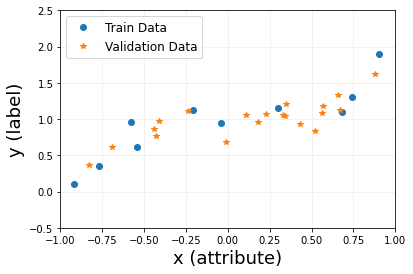

In [29]:
plt.plot(xTrain, yTrain, 'o', label="Train Data")
plt.plot(xVal, yVal, '*', label="Validation Data")
plt.xlabel("x (attribute)", fontsize=18)
plt.ylabel("y (label)", fontsize=18)
plt.xlim(-1,1)
plt.ylim(-0.5,2.5)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.show()

Visually, it is clear that our data follows a cubic pattern. Remember this is a simple dataset that we are using to illustrate key machine learning concepts. In general, we will not be able to determine the complexity of the underlying pattern so easily. 

Let's pretend then that we don't know what the right complexity of our model should be and use a validation set approach to select the complexity (i.e. degree) of the final polynomial model.

In the following cell, we fit again polynomial models of degrees 1 to 9 and calculate their training and validation error. We also plot on the same graph the training dataset, the validation dataset and each fitted polynomial model.

In [ ]:
tbVal = widgets.TabBar([str(order) for order in orders])

MSE_Train = dict.fromkeys(orders)
MSE_Val = dict.fromkeys(orders)


for order in orders:
    with tbVal.output_to(str(order), select= (order < 2)):
    
        p = np.poly1d(np.polyfit(xTrain, yTrain, int(order)))

        MSE_Train[order] = np.sum((yTrain - p(xTrain))**2)/10
        MSE_Val[order] = np.sum((yVal - p(xVal))**2)/20


        plt.plot(xTrain, yTrain, 'o', label='Train data')
        plt.plot(xVal, yVal, '*', label='Validation data')
        plt.plot(x_LS, p(x_LS), '-', alpha=0.8, label='Learned model', linewidth=2)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("y",fontsize=14)
        plt.xlim(-1,1)
        plt.ylim(-0.5,2.5)
        plt.grid(alpha=0.2)
        plt.legend(loc='upper left', fontsize=12)
        plt.show()

        print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(p.c))
        print('The fitted model is:\n {} \n\n---\n'.format(p))
        print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train[order]))
        print('The validation MSE is: {:8.3f} \n\n---\n'.format(MSE_Val[order]))


Explore all the results that you have generated and compare the figures, training MSE values and validation MSE values. It is worth paying a bit more attention to the polynomial of degree 9. Could you tell visually that its performance is excellent on the training dataset but very poor on the validation dataset?

Let's plot the training and validation MSE against the order of the polynomial.

In [ ]:

plt.plot(orders, list(MSE_Train.values()), '--o', label='Training MSE', linewidth=2)
plt.plot(orders, list(MSE_Val.values()), '--*', label='Validation MSE', linewidth=2)

plt.xlabel("Order (degree of the fitted polynomial)", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.xlim(1,9)
plt.ylim(0,0.1)
plt.grid(alpha=0.2)
plt.legend(fontsize=14)
plt.show()

Have a look at the graph. The training MSE and validation MSE behave quite differently as we increes the complexity (degree) of our models. Specifically, the training MSE decreases, while the validation MSE first decreases and then increases. Can you tell which models are underfitting? Which models are overfitting? 

The cubic polynomial seems to be the best choice. Validation has allowed us to identify the right complexity for our polynomial model. We just used validation for **model selection**. What should our final model be? Since we have two datasets (training and validation), we can merge them together and produce a new, larger, training dataset. With this new dataset, we can train a new cubic model. This is the final cubic model that we would send for testing.

Can you create a new code cell where you fit a cubic model to this new dataset?

# Regularisation

When a model is fitted to a training dataset, its coefficients are allowed to take on any value. If we were to restrict the range of values that the coefficients can take on, we would be also restricting the range of shapes that the model can reproduce. In other words, we would be making the model more rigid.

Regularisation is a set of techniques that add some rigidity to our models by restricting the range of values that the coefficients can take on. We will illustrate regularisation in a regression problem that uses the MSE as quality metric. In regularisation, instead of using the MSE as our quality metric **during training**, we use a modified metric which includes a regularisation term, for instance:

$MSER = \frac{1}{N}\sum_{i=1}^N{e_i^2} + \lambda \sum_{k=1}^K w_k^2 = MSE + \lambda \times SSC$

where $N$ is the number of samples, $K$ is the number of coefficients and $\lambda$ is the regularisation parameter. Our optimisation method will then try to find a model that makes both the MSE and the SSC as small as possible. Why do we do this? Remember from previous sections that overfitting models had large SSC values. Hence, our hope is that by building models with low SSC values, we will be reducing the risk of overfitting. 

The regularisation parameter $\lambda$ tells us how important it is for us to reduce the SSC value compared to the training MSE value. If $\lambda$ is small, our optimisation method will pay more attention to reducing the MSE value. If it is large, reducing the SSC value will be more important.


In this section we will fit the polynomial model of order 9 using this regularisation approach. In the following cell, we implement ourselves the exact least squares solution with regularisation (see slide 37 of week 3's lecture notes) and obtain the regularised least squares solution for different values of lambda: 

In [ ]:
myLambdas =[0, 10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10]

tbReg = widgets.TabBar([str(myLambda) for myLambda in myLambdas])

MSE_Train = dict.fromkeys(myLambdas)
MSE_Val = dict.fromkeys(myLambdas)

for myLambda in myLambdas:
    with tbReg.output_to(str(myLambda), select= (myLambda < 2)):

        XTrain = np.column_stack([np.ones(xTrain.shape), xTrain, xTrain**2, xTrain**3, xTrain**4, xTrain**5, xTrain**6, xTrain**7, xTrain**8, xTrain**9]) 
        XVal = np.column_stack([np.ones(xVal.shape), xVal, xVal**2, xVal**3, xVal**4, xVal**5, xVal**6, xVal**7, xVal**8, xVal**9])
        w = np.dot(np.dot(np.linalg.inv(np.dot(XTrain.T, XTrain) + 10*myLambda*np.identity(10)), XTrain.T), yTrain)

        X_LS = np.column_stack([np.ones(x_LS.shape), x_LS, x_LS**2, x_LS**3, x_LS**4, x_LS**5, x_LS**6, x_LS**7, x_LS**8, x_LS**9])
        y_LS = np.dot(X_LS, w)

        MSE_Train[myLambda] = np.sum((yTrain - np.dot(XTrain, w))**2)/10
        MSE_Val[myLambda] = np.sum((yVal - np.dot(XVal, w))**2)/20

        plt.plot(xTrain, yTrain, 'o', label="Dataset")
        plt.plot(xVal, yVal, 'o', label="Dataset")
        plt.plot(x_LS, y_LS, label="Degree 4 prediction")
        plt.xlabel("x (attribute)", fontsize=18)
        plt.ylabel("y (label)", fontsize=18)
        plt.xlim(-1,1)
        plt.ylim(-0.5,2.5)
        plt.grid(alpha=0.2)
        plt.legend(fontsize=12)
        plt.show()

        print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(w))
        print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train[myLambda]))
        print('The validation MSE is: {:8.3f} \n\n---\n'.format(MSE_Val[myLambda]))
        print("The SSC is: {:8.3f}".format(sum(w**2)))


Notice that as we increase the value of lambda, the complexity of the fitted model decreases. The SSC values also decrease, as optimisation will focus more on reducing the SSC values. When lambda is 10, the resulting model is practically a constant model and the SSC is close to 0. Does this result make sense to you?

We can plot the training and validation values as a function of lambda. We can see that the validation MSE decreases dramatically between the values $10^{-7}$ and $10^{-2}$, indicating that we have successfully avoided overfitting within this range. Compare these results with the models plotted previously.

In [ ]:
plt.plot(myLambdas, list(MSE_Train.values()), '--o', label='Training MSE', linewidth=2, )
plt.plot(myLambdas, list(MSE_Val.values()), '--*', label='Validation MSE', linewidth=2, )

plt.xlabel("Lambda", fontsize=12)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(fontsize=14)
plt.xscale('log')
plt.show()

# Up for a challenge?

  
Collect the training and validation datasets into a single dataset and run the following steps several times (for instance, 15 times):

1.   Split **randomly** this dataset into a new training dataset containing 10 samples and a validation dataset containing 20 samples. 
2.   Fit a **linear model** and a **polynomial model of degree 9** to the training dataset, and store the resulting coefficients.
3.   Obtain and store the training and validation **MSE** of each model.

By doing this, you will have obtained 15 different linear and degree-9 polynomials. Plot all the linear models on one graph and all the degree-9 polynomial models on another. How different are the linear models to one another? And the 9-degree polynomial models? What about the MSE values, are they always the same? What is happening?


# Summary

In this lab, we have explored **overfitting** using a simple dataset. Overfitting is a key concept in machine learning and describes the situation where our models perform very well on the training dataset, but have a poor deployment performance. To assess the deployment performance, we use a dataset consisting of samples that our model has not seen before.

Overfitting typically occurs in situations where our dataset is small and our model is very complex. Note that a polynomial of order 9 has 10 coefficients and our training dataset consisted of 10 samples. This can be seen as a problem with 10 unknowns (coefficients) and 10 equations (one per sample). Therefore, we could expect to find a solution capable of predicting every single sample in the training dataset.

We have implemented a simple **validation approach** to select the right degree for our polynomial model. This goal is sometimes called **model selection**, and shouldn't be confused with **model training**, where we tune a family of models. Finally, we have used **regularisation** to penalise models with large coefficients. By doing this, we hope to add rigidity to our models and reduce the risk of overfitting.

Remember that this is your notebook. You can explore further the examples that we have provided, make changes, improve it and be creative. You have an excellent opportunity to ask yourself "what would happen if" and experiment. You do not need to restrict yourself to the script.

Have a go at the corresponding quiz when you feel ready.

## Quiz 4

In [32]:
quiz4xTrain = np.load('quiz4xTrain.npy')
print("The type of 'myDigits' is", type(quiz4xTrain))
print("The array 'myDigits' consists of elements of type", quiz4xTrain.dtype)
print("The array 'myDigits' has", quiz4xTrain.ndim, "dimensions")
print("The shape of 'myDigits' is", quiz4xTrain.shape)
print(quiz4xTrain)


The type of 'myDigits' is <class 'numpy.ndarray'>
The array 'myDigits' consists of elements of type float64
The array 'myDigits' has 1 dimensions
The shape of 'myDigits' is (12,)
[-2.14   2.447 -2.475 -0.495 -1.763  1.086 -2.393 -1.41  -0.457  2.055
  1.452  1.948]


In [35]:
quiz4xVal = np.load('quiz4xVal.npy')
print("The type of 'myDigits' is", type( quiz4xVal))
print("The array 'myDigits' consists of elements of type",  quiz4xVal.dtype)
print("The array 'myDigits' has",  quiz4xVal.ndim, "dimensions")
print("The shape of 'myDigits' is",  quiz4xVal.shape)
print(quiz4xVal)

The type of 'myDigits' is <class 'numpy.ndarray'>
The array 'myDigits' consists of elements of type float64
The array 'myDigits' has 1 dimensions
The shape of 'myDigits' is (10,)
[ 0.833 -1.99  -2.391 -0.383 -2.221 -1.161  0.578  2.31   1.946  1.58 ]


In [36]:
quiz4yTrain = np.load('quiz4yTrain.npy')
print("The type of 'myDigits' is", type( quiz4yTrain))
print("The array 'myDigits' consists of elements of type",  quiz4yTrain.dtype)
print("The array 'myDigits' has",  quiz4yTrain.ndim, "dimensions")
print("The shape of 'myDigits' is",  quiz4yTrain.shape)
print(quiz4yTrain)

The type of 'myDigits' is <class 'numpy.ndarray'>
The array 'myDigits' consists of elements of type float64
The array 'myDigits' has 1 dimensions
The shape of 'myDigits' is (12,)
[21.04  59.436 64.149  2.931 -0.341 -6.044 45.858 -9.116  4.765 13.01
 -6.201  8.661]


In [37]:
quiz4yVal = np.load('quiz4yVal.npy')
print("The type of 'myDigits' is", type( quiz4yVal))
print("The array 'myDigits' consists of elements of type",  quiz4yVal.dtype)
print("The array 'myDigits' has",  quiz4yVal.ndim, "dimensions")
print("The shape of 'myDigits' is",  quiz4yVal.shape)
print(quiz4yVal)

The type of 'myDigits' is <class 'numpy.ndarray'>
The array 'myDigits' consists of elements of type float64
The array 'myDigits' has 1 dimensions
The shape of 'myDigits' is (10,)
[-2.056 10.987 49.973  0.834 28.018 -8.877  1.004 37.263  8.802 -6.355]


In [38]:
quiz4xTrain
quiz4yTrain
quiz4xVal
quiz4yVal

array([-2.056, 10.987, 49.973,  0.834, 28.018, -8.877,  1.004, 37.263,
        8.802, -6.355])

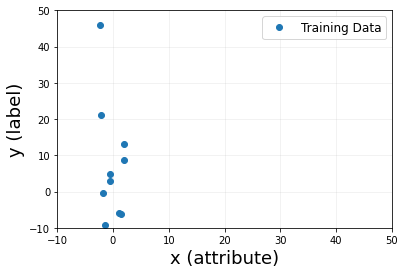

In [40]:
plt.plot(quiz4xTrain, quiz4yTrain, 'o', label="Training Data")
plt.xlabel("x (attribute)", fontsize=18)
plt.ylabel("y (label)", fontsize=18)
plt.xlim(-10,50)
plt.ylim(-10,50)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.show()

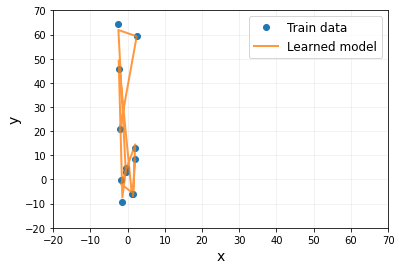

The coefficients of the fitted model are:
 [ 2.758e-03 -6.696e-03  3.884e+00  1.150e-01 -1.473e+01 -6.395e-02
  6.680e+00] 

---

The fitted model is:
           6            5         4         3         2
0.002758 x - 0.006696 x + 3.884 x + 0.115 x - 14.73 x - 0.06395 x + 6.68 

---

The training MSE is:    2.892 

---

The SSC is:  276.833


In [41]:
        p = np.poly1d(np.polyfit(quiz4xTrain, quiz4yTrain, int(6)))

        yPredTrain = p(quiz4xTrain)
        error = quiz4yTrain - yPredTrain
        errorSq = error**2
        MSE_Train = np.sum(errorSq)/10

        plt.plot(quiz4xTrain, quiz4yTrain, 'o', label='Train data')
        plt.plot(quiz4xTrain, p(quiz4xTrain), '-', alpha=0.8, label='Learned model', linewidth=2)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("y",fontsize=14)
        plt.xlim(-20,70)
        plt.ylim(-20,70)
        plt.grid(alpha=0.2)
        plt.legend(loc='upper right', fontsize=12)
        plt.show()

        print('The coefficients of the fitted model are:\n {} \n\n---\n'.format(p.c))
        print('The fitted model is:\n {} \n\n---\n'.format(p))
        print('The training MSE is: {:8.3f} \n\n---\n'.format(MSE_Train))
        print("The SSC is: {:8.3f}".format(sum(p.c**2)))

In [42]:
np.set_printoptions(precision=2)
p(quiz4xTrain[0])

20.20590892682479